## Load Data

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pickle
def load_pkl(fn):
    with open(fn,"rb") as file:
        return pickle.load(file)

import torch
import numpy as np
import matplotlib.pyplot as plt
from dipeptides.data import XYZData

cutoff = 4.0
edata = XYZData(batch_size=1,cutoff=cutoff)
atomic_nums = []
for batch in edata.val_dataloader():
    atomic_nums.append(batch["atomic_numbers"].numpy())
atomic_nums = np.hstack(atomic_nums)
exdatabatch = batch

## Load Models

In [12]:
#Losses
import torch
from cace.tasks import GetLoss
e_loss = GetLoss(
    target_name="energy",
    predict_name='pred_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1,
)
f_loss = GetLoss(
    target_name="force",
    predict_name='pred_force',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000,
)
losses = [e_loss,f_loss]

#Metrics
from cace.tools import Metrics
e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["rmse"],
            per_atom=True,
        )
f_metric = Metrics(
            target_name="force",
            predict_name='pred_force',
            metric_keys=["rmse"],
            name='f',
        )
metrics = [e_metric,f_metric]

In [13]:
from cace.tasks import LightningData, LightningTrainingTask
from dipeptides.model import make_cace_lr

#LR model
lr_model = make_cace_lr(cutoff=cutoff,lr=True)
lr_model.cuda()
lr_model(exdatabatch.cuda())
lr_task = LightningTrainingTask(lr_model,losses=losses,metrics=metrics,
                             logs_directory="model_runs/lightning_logs",name="lol",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = "models/lr-model.ckpt"
lr_task.load(chkpt)
lr_task.model.cuda();

Loading model from models/lr-model.ckpt ...
Loading successful!


## Charges / Dipoles / Quads

In [14]:
#R2 scores
def calc_r2(x,y):
    r = scipy.stats.pearsonr(x,y)[0]
    r2 = r**2
    return np.round(r2,3)

charges = load_pkl("data/val_charges.pkl")
dipoles = load_pkl("data/dipeptide_dipoles.pkl")
quads = load_pkl("data/dipeptide_quads.pkl")

import scipy
print("MBI vs. NN charges:",calc_r2(charges["pred"],charges["mbi"]))
print("#######################")
print("MBI vs. NN dipoles:",calc_r2(dipoles["pred"].ravel(),dipoles["mbi"].ravel()))
print("DFT vs. NN dipoles:",calc_r2(dipoles["pred"].ravel(),dipoles["dft"].ravel()))
print("DFT vs. MBI dipoles:",calc_r2(dipoles["mbi"].ravel(),dipoles["dft"].ravel()))
print("#######################")
print("MBI vs. NN quads:",calc_r2(quads["pred"].ravel(),quads["mbi"].ravel()))
print("DFT vs. NN quads:",calc_r2(quads["pred"].ravel(),quads["dft"].ravel()))
print("DFT vs. MBI quads:",calc_r2(quads["mbi"].ravel(),quads["dft"].ravel()))

MBI vs. NN charges: 0.859
#######################
MBI vs. NN dipoles: 0.976
DFT vs. NN dipoles: 0.987
DFT vs. MBI dipoles: 0.995
#######################
MBI vs. NN quads: 0.975
DFT vs. NN quads: 0.91
DFT vs. MBI quads: 0.922


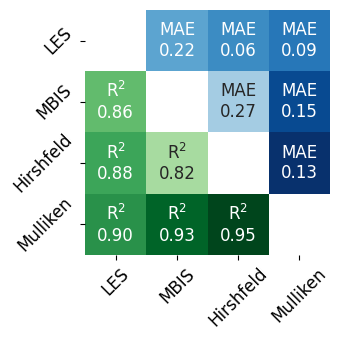

In [15]:
import seaborn as sns
df = load_pkl("data/val_charges.pkl").drop("idx",axis="columns")
df = df.rename({"pred":"LES","hirsh":"Hirshfeld","mbi":"MBIS","mul":"Mulliken"},axis="columns")
df = df.loc[:,["LES","MBIS","Hirshfeld","Mulliken"]]
r2 = df.corr()**2
r22 = r2.copy()
for i,col1 in enumerate(r2.columns):
    for j,col2 in enumerate(r2.columns):
        if j > i:
            mae = np.round(np.abs(df[col1] - df[col2]).mean(),2)
            r2.loc[col1,col2] = f"MAE\n{mae:.2f}"
        else:
            d = np.round(r2.loc[col1,col2],2)
            r2.loc[col1,col2] = f"R$^2$\n{d:.2f}"
plt.subplots(figsize=(4,3.5))
plt.gca().set_aspect('equal')

mask1 = np.zeros_like(r2)
mask2 = np.zeros_like(r2)
mask1[np.tril_indices_from(r2)] = True
mask2[np.triu_indices_from(r2)] = True


# ax1 = sns.heatmap(data, vmin=25, cmap=cmap1, cbar_kws={'pad': -0.02})
# sns.heatmap(data, vmin=0, vmax=25, cmap=cmap2, ax=ax1)

vmin, vmax = 0.75,0.95
ax1 = sns.heatmap(r22,mask=mask2,annot=np.array(r2),cmap='Greens',vmin=vmin,vmax=vmax,
            cbar=False,annot_kws={"size": 12},fmt = '')
sns.heatmap(r22,mask=mask1,annot=np.array(r2),cmap='Blues',vmin=vmin,vmax=vmax,
            cbar=False,annot_kws={"size": 12},fmt = '',ax=ax1)

tcks = [0.5,1.5,2.5,3.5]
tcks2 = ["LES","MBIS","Hirshfeld","Mulliken"]
plt.xticks(tcks,tcks2,fontsize=12,rotation=45)
plt.yticks(tcks,tcks2,fontsize=12,rotation=45)
plt.tight_layout()
plt.savefig("figures/charges_r2.png",dpi=500)

## Charges

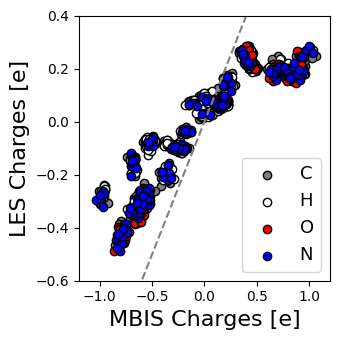

In [16]:
fs=16
djvfont = {'fontname':'DejaVu Sans'}
eltrans = {1:"H",6:"C",7:"N",8:"O"}
colors = {1:"white",6:"grey",7:"blue",8:"red"}
plt.subplots(figsize=(3.5,3.5))
mbi_charges = np.array(charges["mbi"])
nn_charges = np.array(charges["pred"])
for el in [6,1,8,7]:
    idx = np.where(atomic_nums == el)[0]
    mbi = mbi_charges[idx]
    nnc = nn_charges[idx]
    plt.scatter(mbi,nnc,label=eltrans[el],color=colors[el],edgecolors='black')
xmin, xmax = -1.25,1.26
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(-1.2,1.2)
plt.ylim(-0.6,0.4)
s = 0.5
# plt.xticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
# plt.yticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.xlabel("MBIS Charges [e]",fontsize=fs,**djvfont)
plt.ylabel("LES Charges [e]",fontsize=fs,**djvfont)
plt.legend(loc="lower right",prop={'family':'DejaVu Sans', 'size':fs-3})
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/les_vs_mbi.png",dpi=500)

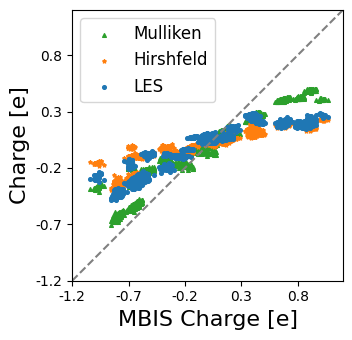

In [17]:
import numpy as np
df = charges
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
df = load_pkl("data/val_charges.pkl")
size = 7
plt.scatter(df["mbi"],df["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(df["mbi"],df["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(df["mbi"],df["pred"],label="LES",marker="o",s=size,c="tab:blue")
s = 0.5
xmin, xmax = -1.2,1.2
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.yticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.legend(loc="upper left",prop={'size': 12})
# plt.title("Charge Comparison",fontsize=fs,**djvfont)
plt.xlabel("MBIS Charge [e]",fontsize=fs,**djvfont)
plt.ylabel("Charge [e]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/charge_comparison.png",dpi=500)

## Dipole Moments

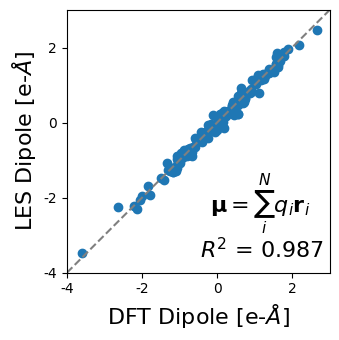

In [18]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
xdata, ydata = dipoles["dft"].ravel(),dipoles["pred"].ravel()
r2 = calc_r2(xdata,ydata)
plt.scatter(xdata,ydata)
fs=16
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("LES Dipole [e-$\AA$]",fontsize=fs,**djvfont)
xmin, xmax = -4,3
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 2
plt.xticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.yticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.text(-0.2,-2.4,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.45,-3.6,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/dipoles_dft_les.png",dpi=500)

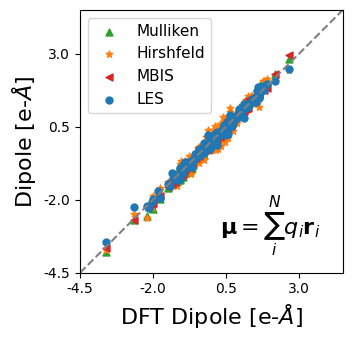

In [19]:
import numpy as np
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
size = 25
plt.scatter(dipoles["dft"],dipoles["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(dipoles["dft"],dipoles["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(dipoles["dft"],dipoles["mbi"],label="MBIS",marker="<",s=size,c="tab:red")
plt.scatter(dipoles["dft"],dipoles["pred"],label="LES",marker="o",s=size,c="tab:blue")
s = 2.5
xmin, xmax = -4.5,4.5
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.yticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.legend(loc="upper left",prop={'size': 11})
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.text(0.3,-3.2,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.tight_layout()
plt.savefig("figures/dipole_comparison.png",dpi=500)

## Quadrupoles

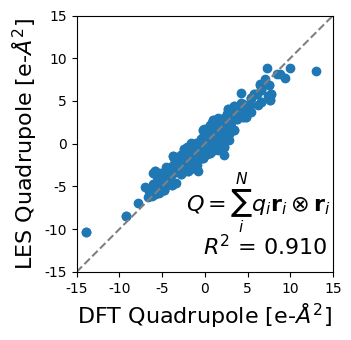

In [20]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
xdata, ydata = quads["dft"].ravel(),quads["pred"].ravel()
r2 = calc_r2(xdata,ydata)
plt.scatter(xdata,ydata)
fs=16
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("LES Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
xmin, xmax = -15,15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.text(-2.2,-8,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.2,-13,f"$R^2$ = {r2}0",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/quads_dft_les.png",dpi=500)

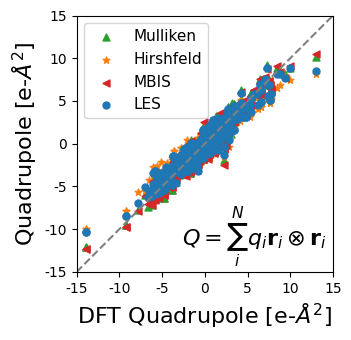

In [21]:
import numpy as np
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
size = 25
plt.scatter(quads["dft"],quads["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(quads["dft"],quads["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(quads["dft"],quads["mbi"],label="MBIS",marker="<",s=size,c="tab:red")
plt.scatter(quads["dft"],quads["pred"],label="LES",marker="o",s=size,c="tab:blue")
xmin, xmax = -15, 15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.legend(loc="upper left",prop={'size': 11})
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.text(-2.7,-12,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.tight_layout()
plt.savefig("figures/quadrupole_comparison.png",dpi=500)

## BEC

In [27]:
import cace
import pandas as pd
import numpy as np

#Takes a bit to run
class BEC():
    def __init__(self,remove_mean=False):
        model = lr_task.model.model
        model.cuda()

        #Remove_mean=False but can also do True, small difference
        polarization = cace.modules.polarization.Polarization(remove_mean=remove_mean)        
        bec = cace.modules.grad.Grad(
            y_key = 'polarization',
            x_key = 'positions',
            output_key = 'bec'
        )

        true_bec = []
        pred_bec = []
        for batch in edata.val_dataloader():
            batch_bec = batch["bec"].reshape(batch["bec"].shape[0],3,3)
            true_bec.append(batch_bec.cpu().detach().numpy())
            
            batch.cuda()
            out = model.forward(batch,training=True)
            batch["q"] = out["q"]
            batch = polarization(batch)
            batch = bec(batch)
            pred_bec.append(batch["bec"].cpu().detach().numpy())
            torch.cuda.empty_cache()

        self.true_bec = np.vstack(true_bec)
        self.pred_bec = np.vstack(pred_bec)

obj = BEC()

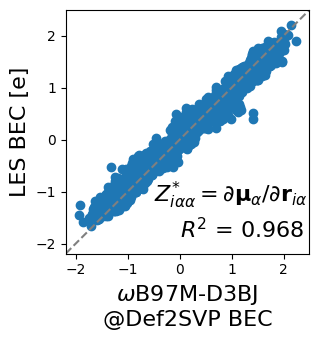

In [30]:
def get_diag(arr,diag=True):
    arr = torch.tensor(arr)
    mask = torch.zeros_like(arr)
    mv = torch.diagonal(mask,dim1=1,dim2=2)
    mv += 1
    if diag:
        return arr[mask.bool()].numpy()
    else:
        return arr[~mask.bool()].numpy()

import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = True
truex = get_diag(obj.true_bec,diag=diag)
predx = get_diag(obj.pred_bec,diag=diag)
xmin = min(np.min(truex),np.min(predx)) - 0.25
xmax = max(np.max(truex),np.max(predx)) + 0.25
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\alpha}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\alpha}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/diagonal_bec.png",dpi=500)

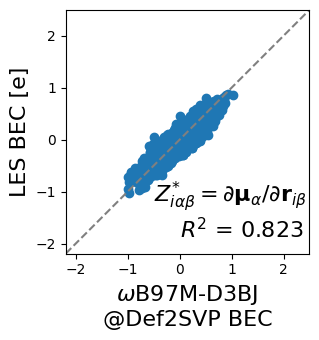

In [31]:
import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = False
truex = get_diag(obj.true_bec,diag=diag)
predx = get_diag(obj.pred_bec,diag=diag)
xmin = -2.190323031838511
xmax = 2.49442159708481
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\beta}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\beta}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/nondiagonal_bec.png",dpi=500)